In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, tree
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import math
import glob
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, ShuffleSplit, LearningCurveDisplay
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB
from imblearn.under_sampling import RandomUnderSampler
plt.style.use('default')
%matplotlib inline

In [3]:
# Загрузка матрицы признаков
feature_matrix =  pd.read_csv('feature_matrix_128.csv', na_values=["?"])
total_matrix = feature_matrix.copy()

total_matrix = feature_matrix.drop(columns = ['Unnamed: 0'])
total_matrix.head()

,Ax_MAV,Ax_CD,Ax_MAX,Ax_MIN,Ax_INIT,Ax_FNL,Ay_MAV,Ay_CD,Ay_MAX,Ay_MIN,...,RF_IEMG,RF_MAV,RF_LOG,RF_WL,RF_ACC,RF_DASDV,RF_ZC,RF_WAMP,RF_MYOP,Mode
0,-0.082788,0.194516,0.098621,-0.553145,-0.548947,-0.006729,0.193257,0.105025,0.482086,0.086829,...,0.659565,0.002199,0.057953,0.369797,0.001233,0.001564,52.0,0.0,0.0,0.0
1,-0.147134,0.218421,0.104413,-0.572925,-0.035088,0.104413,0.229532,0.130144,0.504380,0.085965,...,0.584493,0.001948,0.056085,0.381330,0.001271,0.001618,64.0,0.0,0.0,0.0
2,-0.095318,0.186721,0.104413,-0.572925,0.038609,-0.461041,0.214915,0.111148,0.504380,0.085965,...,0.543723,0.001812,0.054427,0.403360,0.001345,0.001724,74.0,0.0,0.0,0.0
3,-0.072635,0.191764,0.104413,-0.585118,-0.343078,-0.001161,0.194778,0.117547,0.532462,0.081685,...,0.564877,0.001883,0.055629,0.378346,0.001261,0.001626,59.0,0.0,0.0,0.0
4,-0.164038,0.216013,0.100683,-0.585118,-0.002821,-0.013294,0.248497,0.134200,0.532462,0.075260,...,0.543924,0.001813,0.054203,0.387581,0.001292,0.001632,61.0,0.0,0.0,0.0


In [4]:
x_raw = total_matrix.copy()
y = x_raw['Mode']
x_raw = x_raw.copy().drop(columns=['Mode'])
rus = RandomUnderSampler()
x_raw, y = rus.fit_resample(x_raw, y)
print(x_raw[y==0].shape)
print(x_raw[y==1].shape)

(3585, 92)
(3585, 92)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [6]:
normalizer1 = preprocessing.StandardScaler()
X_train = pd.DataFrame(normalizer1.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(normalizer1.fit_transform(X_test), columns=X_test.columns)

In [7]:
clf_dt = tree.DecisionTreeClassifier(criterion="log_loss", max_depth=15, min_samples_leaf=1, max_leaf_nodes=300)
clf_dt = clf_dt.fit(X_train, y_train)

In [8]:
max_depth = list([5, 10, 15, 20])
min_samples_leaf = list([1, 10, 20, 30])
max_leaf_nodes = list([50, 100, 200, 300])
param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes)
grid = GridSearchCV(clf_dt, param_grid, cv=10, n_jobs=3, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

KeyboardInterrupt: 

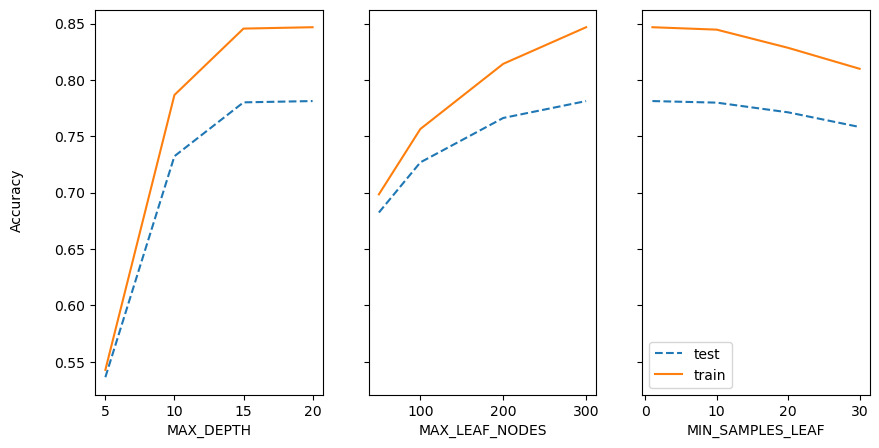

In [16]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(10,5))
    fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        #e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        ax[i].plot(x, y_1, linestyle='--', label='test')
        ax[i].plot(x, y_2, linestyle='-',label='train' )
        
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(grid)

In [9]:
clf_dt = tree.DecisionTreeClassifier(criterion="log_loss", max_depth=20, min_samples_leaf=1, max_leaf_nodes=300)
clf_dt = clf_dt.fit(X_train, y_train)

In [10]:
y_pred = clf_dt.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       731
         1.0       0.58      0.54      0.56       713
         2.0       0.77      0.78      0.77       707
         3.0       0.74      0.78      0.76       727
         4.0       0.87      0.86      0.86       702
         5.0       0.85      0.83      0.84       726
         6.0       0.74      0.76      0.75       713

    accuracy                           0.78      5019
   macro avg       0.78      0.78      0.78      5019
weighted avg       0.78      0.78      0.78      5019



              precision    recall  f1-score   support

         0.0      0.890     0.889     0.890       731
         1.0      0.584     0.543     0.562       713
         2.0      0.769     0.778     0.774       707
         3.0      0.737     0.776     0.756       727
         4.0      0.869     0.858     0.863       702
         5.0      0.846     0.832     0.839       726
         6.0      0.736     0.763     0.749       713

    accuracy                          0.777      5019
   macro avg      0.776     0.777     0.776      5019
weighted avg      0.776     0.777     0.776      5019



[Text(0, 0.5, 'Сидение'),
 Text(0, 1.5, 'Ходьба по ровной поверхности'),
 Text(0, 2.5, 'Подъем по рампе'),
 Text(0, 3.5, 'Спуск по рампе'),
 Text(0, 4.5, 'Подъем по лестнице'),
 Text(0, 5.5, 'Спуск по лестнице'),
 Text(0, 6.5, 'Стояние')]

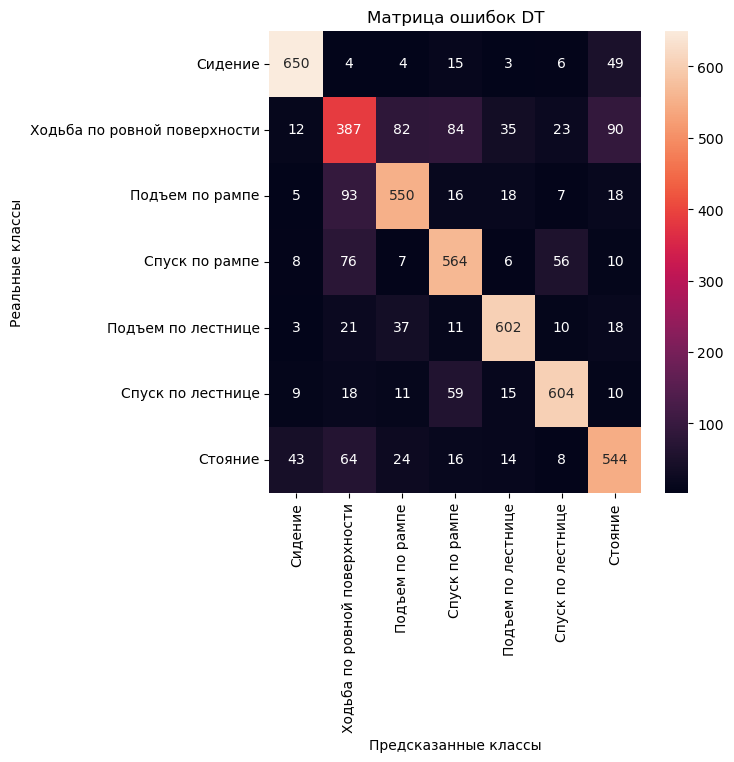

In [11]:
target_names = ['Sitting', 'Level ground walking', 'Ramp ascent', 'Ramp descent', 'Stair ascent', 'Stair descent', 'Standing']
print(classification_report(y_test, y_pred, digits = 3))
cm = confusion_matrix(y_test, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = ['Сидение', 'Ходьба по ровной поверхности', 'Подъем по рампе', 'Спуск по рампе', 'Подъем по лестнице', 'Спуск по лестнице', 'Стояние']
fig, ax = plt.subplots(figsize=(6,6))  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Предсказанные классы')
ax.set_ylabel('Реальные классы') 
ax.set_title('Матрица ошибок DT') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)

[Text(0.6358007217236709, 0.96875, 'x[3] <= 0.819\nlog_loss = 2.807\nsamples = 20076\nvalue = [2854.0, 2872.0, 2878.0, 2858.0, 2883.0, 2859.0, 2872.0]'),
 Text(0.2915811251269895, 0.90625, 'x[1] <= -0.711\nlog_loss = 2.693\nsamples = 17304\nvalue = [461, 2853, 2839, 2855, 2850, 2835, 2611]'),
 Text(0.119962749746021, 0.84375, 'x[39] <= 1.056\nlog_loss = 2.272\nsamples = 3857\nvalue = [248.0, 558.0, 424.0, 269.0, 299.0, 178.0, 1881.0]'),
 Text(0.06755841517101253, 0.78125, 'x[42] <= 0.1\nlog_loss = 2.74\nsamples = 1776\nvalue = [164, 191, 311, 261, 279, 173, 397]'),
 Text(0.028445648493057907, 0.71875, 'x[86] <= -0.159\nlog_loss = 2.438\nsamples = 844\nvalue = [148, 106, 26, 258, 8, 165, 133]'),
 Text(0.010836437521164918, 0.65625, 'x[0] <= -0.599\nlog_loss = 2.239\nsamples = 271\nvalue = [57, 78, 20, 21, 5, 2, 88]'),
 Text(0.008127328140873687, 0.59375, 'log_loss = 1.567\nsamples = 55\nvalue = [0.0, 31.0, 15.0, 0.0, 5.0, 0.0, 4.0]'),
 Text(0.013545546901456146, 0.59375, 'x[37] <= -0.56

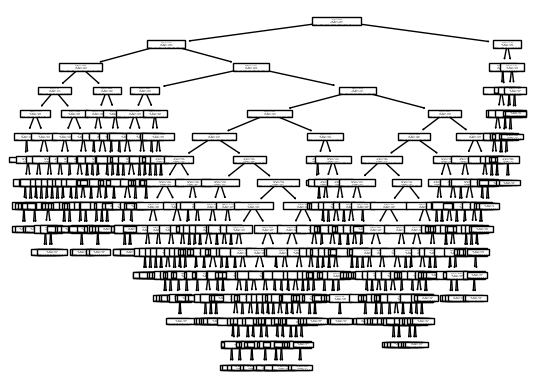

In [10]:
tree.plot_tree(clf_dt)